____
__Universidad de San Andrés__<br/>
__Visión Artificial__<br/>
__Trabajo Práctico 1: Panorámica__<br/>
__Martin Bianchi y Federico Gutman__
____

### Importamos las librerías necesarias

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Visualizamos las imágenes

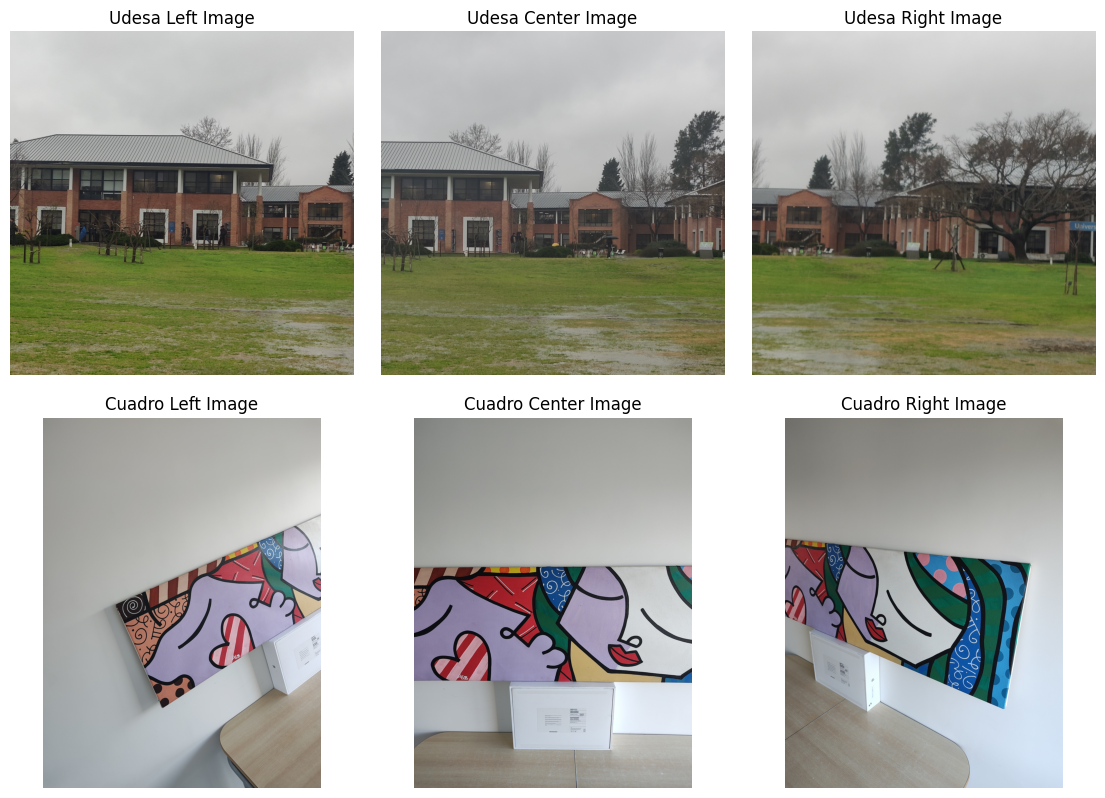

In [3]:
import cv2, numpy as np, matplotlib.pyplot as plt

# ===== Función 1: visualización 2x3 =====
def show_triplets_2x3(row1, row2, row1_label="Udesa", row2_label="Cuadro",
                      titles=("Left Image","Center Image","Right Image"),
                      figsize=(14,10), wspace=0.08, hspace=0.08):
    fig, ax = plt.subplots(2, 3, figsize=figsize,
                           gridspec_kw={'wspace':wspace, 'hspace':hspace})
    for j in range(3):
        ax[0, j].imshow(row1[j]); ax[0, j].set_title(f"{row1_label} {titles[j]}"); ax[0, j].axis('off')
        ax[1, j].imshow(row2[j]); ax[1, j].set_title(f"{row2_label} {titles[j]}"); ax[1, j].axis('off')
    plt.show()

# ================= Fragmento 1 (con función) =================
# cargo imágenes y paso a RGB
udesa  = [cv2.cvtColor(cv2.imread(f"img/udesa_{i}.jpg"),  cv2.COLOR_BGR2RGB) for i in range(3)]
cuadro = [cv2.cvtColor(cv2.imread(f"img/cuadro_{i}.jpg"), cv2.COLOR_BGR2RGB) for i in range(3)]

# muestro en una figura 2x3
show_triplets_2x3(udesa, cuadro)



### Seguimos el pipeline propuesto

#### Paso 1: Detección de características visuales

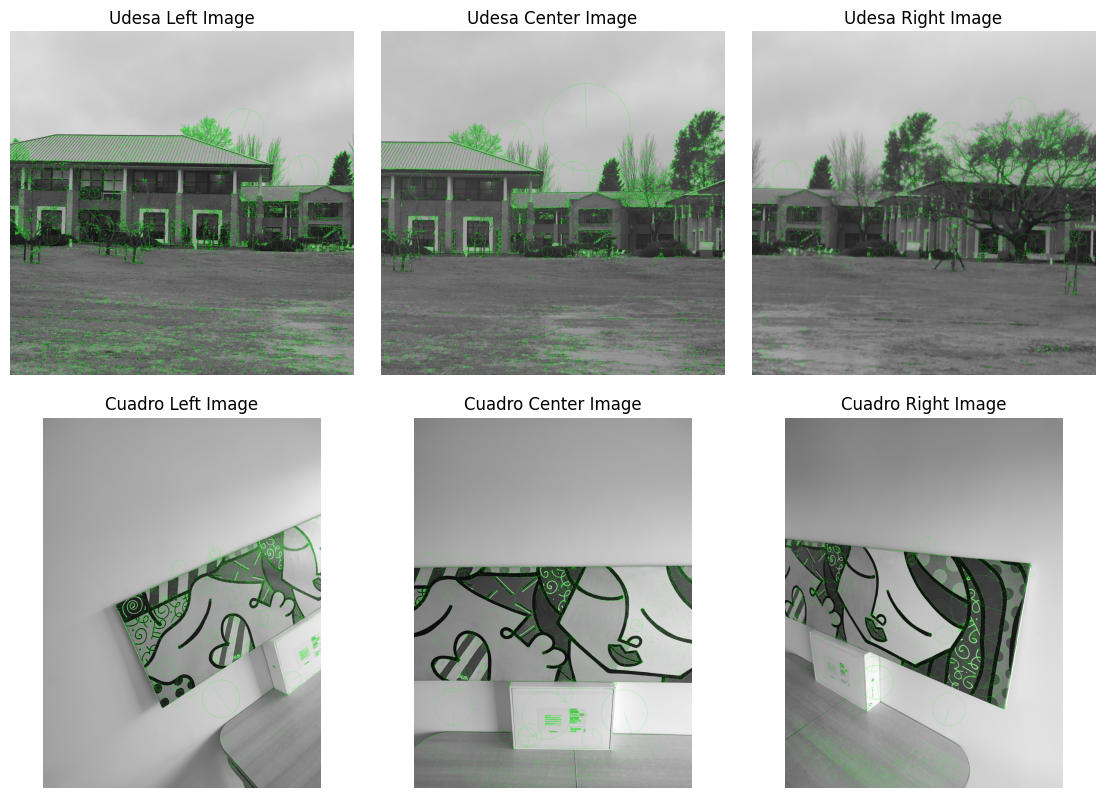

In [4]:
# ===== Función 2: SIFT sobre triplete RGB + keypoints dibujados =====
def sift_kps_images(rgb_triplet):
    """rgb_triplet: [left, center, right] en RGB. Devuelve (kps_list, desc_list, vis_list_RGB)."""
    sift = cv2.SIFT_create()
    kps_list, desc_list, vis_list = [], [], []
    for img_rgb in rgb_triplet:
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        kps, desc = sift.detectAndCompute(gray, None)
        kps_list.append(kps); desc_list.append(desc)
        vis_bgr = cv2.drawKeypoints(gray, kps, None, (0,255,0),
                                    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        vis_list.append(cv2.cvtColor(vis_bgr, cv2.COLOR_BGR2RGB))
    return kps_list, desc_list, vis_list

# ================= Fragmento 2 (reutilizando funciones) =================
# SIFT + keypoints para ambos tripletes
(kps_u, desc_u, vis_u) = sift_kps_images(udesa)
(kps_c, desc_c, vis_c) = sift_kps_images(cuadro)

# muestro las imágenes con keypoints en la misma figura 2x3
show_triplets_2x3(vis_u, vis_c)

#### Paso 2: Supresión de No Máxima Adaptativa

In [ ]:
import cv2, numpy as np, matplotlib.pyplot as plt

# ======================= TU ANMS (SIN CAMBIOS) =======================
def anms(keypoints, descriptors, num_points):
    if len(keypoints) <= num_points:
        return keypoints, descriptors
    
    # inicializo los radios de supresión
    radii = [float('inf')] * len(keypoints)

    # calculo los radios de supresión
    for i in range(len(keypoints)):
        for j in range(len(keypoints)):
            if keypoints[j].response > keypoints[i].response:
                dx = keypoints[i].pt[0] - keypoints[j].pt[0]
                dy = keypoints[i].pt[1] - keypoints[j].pt[1]
                dist = dx*dx + dy*dy
                if dist < radii[i]:
                    radii[i] = dist

    # asocio cada radio con su keypoint y ordeno por radio
    keypoints_radii = list(zip(keypoints, radii))
    keypoints_radii.sort(key=lambda x: x[1], reverse=True)

    # selecciono los primeros num_points keypoints y sus descriptores
    selected_keypoints = [kp for kp, r in keypoints_radii[:num_points]]
    selected_indices = [keypoints.index(kp) for kp in selected_keypoints]
    selected_descriptors = descriptors[selected_indices]
    selected_radii = [r for kp, r in keypoints_radii[:num_points]]

    return selected_keypoints, selected_descriptors, selected_radii

# ======================= PLOTS (MISMO ESTILO QUE TENÍAS) =======================
def plot_triplet_keypoints(image_gray_triplet, kps_orig_triplet, kps_anms_triplet, title_prefix=""):
    """
    Muestra un 2x3: fila superior = keypoints originales,
    fila inferior = keypoints tras ANMS.
    """
    fig, ax = plt.subplots(2, 3, figsize=(14,10),
                           gridspec_kw={'wspace':0.08, 'hspace':0.08})
    names = ["Left", "Center", "Right"]

    # Fila superior: originales
    for j in range(3):
        ax[0, j].imshow(image_gray_triplet[j], cmap='gray'); ax[0, j].axis('off')
        ax[0, j].scatter([kp.pt[0] for kp in kps_orig_triplet[j]],
                         [kp.pt[1] for kp in kps_orig_triplet[j]], s=8, c='g')
        ax[0, j].set_title(f"{title_prefix} {names[j]} - Original")

    # Fila inferior: ANMS
    for j in range(3):
        ax[1, j].imshow(image_gray_triplet[j], cmap='gray'); ax[1, j].axis('off')
        ax[1, j].scatter([kp.pt[0] for kp in kps_anms_triplet[j]],
                         [kp.pt[1] for kp in kps_anms_triplet[j]], s=8, c='g')
        ax[1, j].set_title(f"{title_prefix} {names[j]} - ANMS")

    plt.tight_layout(); plt.show()

# ======================= HELPERS CHIQUITOS =======================
def rgb_to_gray_triplet(rgb_triplet):
    """Convierte [L,C,R] RGB -> GRAY."""
    return [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in rgb_triplet]

def apply_anms_triplet(kps_list, desc_list, N=1000):
    """Aplica tu ANMS a cada imagen del triplete."""
    kps_anms, desc_anms, radii = [], [], []
    for kps, desc in zip(kps_list, desc_list):
        k_sel, d_sel, r_sel = anms(kps, desc, N)
        kps_anms.append(k_sel); desc_anms.append(d_sel); radii.append(r_sel)
    return kps_anms, desc_anms, radii

# ======================= USO: UDESA =======================
# Requisito: ya tener (kps_u, desc_u) del fragmento anterior (tu celda SIFT)
# y las imágenes RGB en la lista 'udesa' = [udesa_0, udesa_1, udesa_2]
udesa_gray = rgb_to_gray_triplet(udesa)
kps_u_anms, desc_u_anms, rad_u = apply_anms_triplet(kps_u, desc_u, N=1000)

# ======================= USO: CUADRO =======================
# Requisito: ya tener (kps_c, desc_c) del fragmento anterior (tu celda SIFT)
# y las imágenes RGB en la lista 'cuadro' = [cuadro_0, cuadro_1, cuadro_2]
cuadro_gray = rgb_to_gray_triplet(cuadro)
kps_c_anms, desc_c_anms, rad_c = apply_anms_triplet(kps_c, desc_c, N=1000)

plot_triplet_keypoints(udesa_gray, kps_u, kps_u_anms, title_prefix="Udesa")
plot_triplet_keypoints(cuadro_gray, kps_c, kps_c_anms, title_prefix="Cuadro")

#### Paso 3: Descripción de las características

[UDESA] Left–Center -> Lowe+Cross: 70 matches
[UDESA] Right–Center -> Lowe+Cross: 21 matches


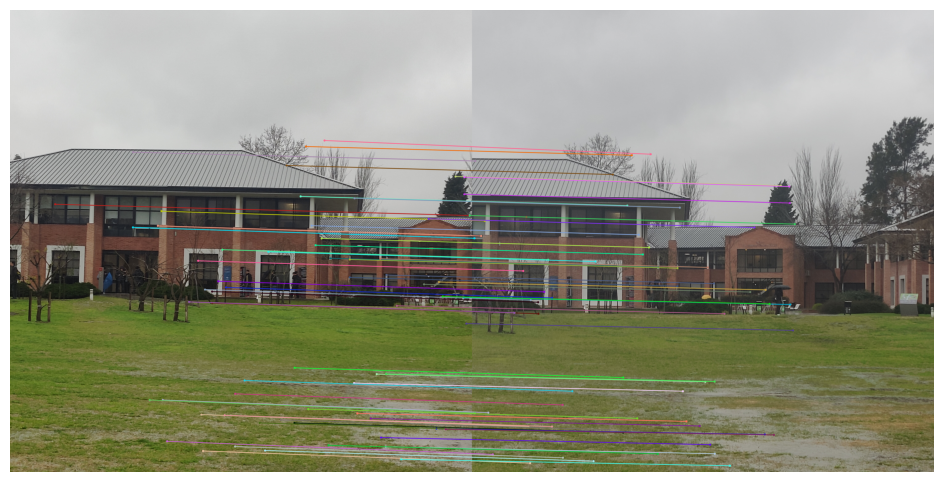

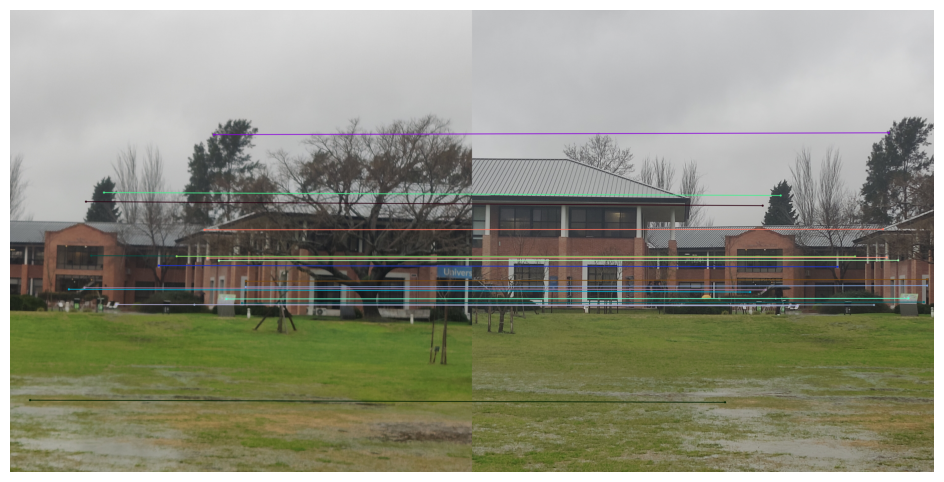

[CUADRO] Left–Center -> Lowe+Cross: 43 matches
[CUADRO] Right–Center -> Lowe+Cross: 18 matches


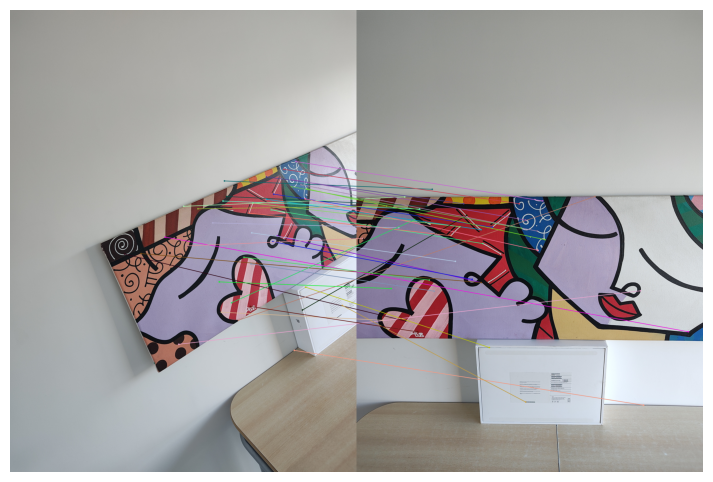

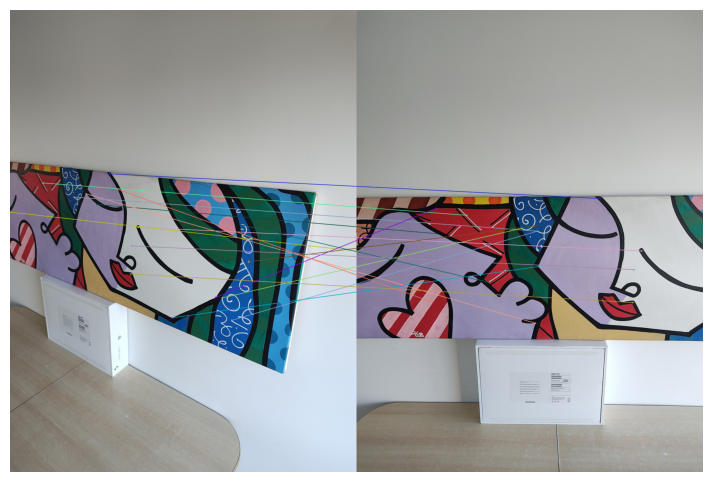

In [ ]:
# --- util mínimo para mostrar matches cuando las imágenes están en RGB (plt/PIL) ---
def _u8(img):
    return (img*255).astype(np.uint8) if img.dtype!=np.uint8 else img

def show_matches_rgb(img1_rgb, kps1, img2_rgb, kps2, matches, max_show=60, title=""):
    img1_u8 = _u8(img1_rgb); img2_u8 = _u8(img2_rgb)
    draw = cv2.drawMatches(cv2.cvtColor(img1_u8, cv2.COLOR_RGB2BGR), kps1,
                           cv2.cvtColor(img2_u8, cv2.COLOR_RGB2BGR), kps2,
                           matches[:max_show], None,
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB))
    plt.title(title); plt.axis('off'); plt.show()

# --- elegir norma según descriptor (SIFT -> L2, ORB/BRIEF -> Hamming) ---
def _norm_for(desc):
    return cv2.NORM_L2 if desc.dtype==np.float32 else cv2.NORM_HAMMING

# 1) Lowe ratio
def match_lowe(kps1, desc1, kps2, desc2, ratio=0.65):
    if desc1 is None or desc2 is None or len(desc1)==0 or len(desc2)==0:
        return [], np.empty((0,2), np.float32), np.empty((0,2), np.float32)
    matcher = cv2.BFMatcher(_norm_for(desc1), crossCheck=False)
    knn = matcher.knnMatch(desc1, desc2, k=2)
    good = []
    for pair in knn:
        if len(pair)<2: continue
        m, n = pair
        if m.distance < ratio * n.distance:
            good.append(m)
    good.sort(key=lambda x: x.distance)
    pts1 = np.array([kps1[m.queryIdx].pt for m in good], np.float32)
    pts2 = np.array([kps2[m.trainIdx].pt for m in good], np.float32)
    return good, pts1, pts2

# 2) Cross-check (mejor vecino recíproco)
def match_crosscheck(kps1, desc1, kps2, desc2):
    if desc1 is None or desc2 is None or len(desc1)==0 or len(desc2)==0:
        return [], np.empty((0,2), np.float32), np.empty((0,2), np.float32)
    matcher = cv2.BFMatcher(_norm_for(desc1), crossCheck=True)
    matches = matcher.match(desc1, desc2)
    matches.sort(key=lambda x: x.distance)
    pts1 = np.array([kps1[m.queryIdx].pt for m in matches], np.float32)
    pts2 = np.array([kps2[m.trainIdx].pt for m in matches], np.float32)
    return matches, pts1, pts2

# 3) Combinado: Lowe + verificación cruzada
def match_lowe_cross(kps1, desc1, kps2, desc2, ratio=0.65):
    if desc1 is None or desc2 is None or len(desc1)==0 or len(desc2)==0:
        return [], np.empty((0,2), np.float32), np.empty((0,2), np.float32)
    norm = _norm_for(desc1)
    bf12 = cv2.BFMatcher(norm, crossCheck=False)
    knn12 = bf12.knnMatch(desc1, desc2, k=2)
    cand = []
    for pair in knn12:
        if len(pair)<2: continue
        m, n = pair
        if m.distance < ratio * n.distance:
            cand.append(m)
    bf21 = cv2.BFMatcher(norm, crossCheck=False)
    knn21 = bf21.knnMatch(desc2, desc1, k=1)
    best21 = {m.queryIdx: m.trainIdx for [m] in knn21}
    good = [m for m in cand if best21.get(m.trainIdx, -1) == m.queryIdx]
    good.sort(key=lambda x: x.distance)
    pts1 = np.array([kps1[m.queryIdx].pt for m in good], np.float32)
    pts2 = np.array([kps2[m.trainIdx].pt for m in good], np.float32)
    return good, pts1, pts2

import cv2, numpy as np, matplotlib.pyplot as plt

def draw_matches_thick_rgb(img1_rgb, kps1, img2_rgb, kps2, matches,
                           max_show=60, thickness=3, radius=6):
    img1 = (img1_rgb*255).astype(np.uint8) if img1_rgb.dtype!=np.uint8 else img1_rgb
    img2 = (img2_rgb*255).astype(np.uint8) if img2_rgb.dtype!=np.uint8 else img2_rgb
    im1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    im2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
    h1, w1 = im1.shape[:2]; h2, w2 = im2.shape[:2]
    H = max(h1, h2)
    canvas = np.zeros((H, w1 + w2, 3), dtype=np.uint8)
    canvas[:h1, :w1] = im1
    canvas[:h2, w1:w1+w2] = im2
    rng = np.random.default_rng(0)
    for m in matches[:max_show]:
        p1 = tuple(int(v) for v in kps1[m.queryIdx].pt)
        p2 = tuple(int(v) for v in kps2[m.trainIdx].pt)
        p2_off = (p2[0] + w1, p2[1])
        color = tuple(int(c) for c in rng.integers(0, 255, size=3))
        cv2.circle(canvas, p1, radius, color, -1)
        cv2.circle(canvas, p2_off, radius, color, -1)
        cv2.line(canvas, p1, p2_off, color, thickness, lineType=cv2.LINE_AA)
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,6))
    plt.imshow(canvas_rgb); plt.axis('off'); plt.show()


# ====================== MATCHING PARA UDESA ======================
# Requiere que existan: udesa = [L,C,R], kps_u_anms (list 3), desc_u_anms (list 3)
ratio = 0.65
udesa_left, udesa_center, udesa_right = udesa

keypoints_left_anms   = kps_u_anms[0]
keypoints_center_anms = kps_u_anms[1]
keypoints_right_anms  = kps_u_anms[2]

descriptors_left_anms   = desc_u_anms[0]
descriptors_center_anms = desc_u_anms[1]
descriptors_right_anms  = desc_u_anms[2]

m_LC, ptsL, ptsC_L = match_lowe_cross(keypoints_left_anms, descriptors_left_anms,
                                      keypoints_center_anms, descriptors_center_anms,
                                      ratio=ratio)
print(f"[UDESA] Left–Center -> Lowe+Cross: {len(m_LC)} matches")

m_RC, ptsR, ptsC_R = match_lowe_cross(keypoints_right_anms, descriptors_right_anms,
                                      keypoints_center_anms, descriptors_center_anms,
                                      ratio=ratio)
print(f"[UDESA] Right–Center -> Lowe+Cross: {len(m_RC)} matches")

draw_matches_thick_rgb(udesa_left,  keypoints_left_anms,  udesa_center, keypoints_center_anms, m_LC,
                       max_show=80, thickness=4, radius=7)
draw_matches_thick_rgb(udesa_right, keypoints_right_anms, udesa_center, keypoints_center_anms, m_RC,
                       max_show=80, thickness=4, radius=7)

# ====================== MATCHING PARA CUADRO ======================
# Requiere que existan: cuadro = [L,C,R], kps_c_anms (list 3), desc_c_anms (list 3)
cuadro_left, cuadro_center, cuadro_right = cuadro

keypoints_left_c_anms   = kps_c_anms[0]
keypoints_center_c_anms = kps_c_anms[1]
keypoints_right_c_anms  = kps_c_anms[2]

descriptors_left_c_anms   = desc_c_anms[0]
descriptors_center_c_anms = desc_c_anms[1]
descriptors_right_c_anms  = desc_c_anms[2]

m_LC_c, ptsL_c, ptsC_L_c = match_lowe_cross(keypoints_left_c_anms, descriptors_left_c_anms,
                                            keypoints_center_c_anms, descriptors_center_c_anms,
                                            ratio=ratio)
print(f"[CUADRO] Left–Center -> Lowe+Cross: {len(m_LC_c)} matches")

m_RC_c, ptsR_c, ptsC_R_c = match_lowe_cross(keypoints_right_c_anms, descriptors_right_c_anms,
                                            keypoints_center_c_anms, descriptors_center_c_anms,
                                            ratio=ratio)
print(f"[CUADRO] Right–Center -> Lowe+Cross: {len(m_RC_c)} matches")

draw_matches_thick_rgb(cuadro_left,  keypoints_left_c_anms,  cuadro_center, keypoints_center_c_anms, m_LC_c,
                       max_show=80, thickness=4, radius=7)
draw_matches_thick_rgb(cuadro_right, keypoints_right_c_anms, cuadro_center, keypoints_center_c_anms, m_RC_c,
                       max_show=80, thickness=4, radius=7)



# (si querés comparar políticas, probá:)
# mL_only, _, _  = match_lowe(kpsL_anms, descL_anms, kpsC_anms, descC_anms, ratio=0.75)
# mCC_only, _, _ = match_crosscheck(kpsL_anms, descL_anms, kpsC_anms, descC_anms)
# print(len(mL_only), len(mCC_only))


#### Paso 4: Estimación de la homografía

##### Homografía entre la imagen central y la izquierda, Homografía entre la imagen central y la derecha

In [ ]:
# ==================== DLT simple + overlay reutilizable ====================
import numpy as np, cv2, matplotlib.pyplot as plt

def compute_homography(src_pts, dst_pts):
    """
    H tal que [x',y',1]^T ~ H [x,y,1]^T (src -> dst)
    src_pts, dst_pts: array (N,2) float, N>=4, mismo orden.
    """
    A = []
    for (x, y), (xp, yp) in zip(src_pts, dst_pts):
        A.append([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        A.append([ 0,  0,  0,-x,-y,-1, x*yp, y*yp, yp])
    A = np.asarray(A, dtype=float)
    _, _, Vt = np.linalg.svd(A)
    h = Vt[-1]; H = h.reshape(3,3)
    return H / H[2,2]

def warp_to_center_and_overlay(moving_rgb, center_rgb, src_pts, dst_pts, title="", alpha=0.5):
    """
    Calcula H (moving->center), warpea moving al tamaño de center y devuelve overlay para chequeo.
    Retorna: H, warped_rgb, overlay_rgb
    """
    H = compute_homography(np.asarray(src_pts, float), np.asarray(dst_pts, float))
    h, w = center_rgb.shape[:2]
    warped = cv2.warpPerspective(moving_rgb, H, (w, h))   # trabaja canal a canal, ok con RGB
    overlay = (alpha*warped + (1-alpha)*center_rgb).astype(np.uint8)

    plt.figure(figsize=(8,6))
    plt.imshow(overlay); plt.title(title); plt.axis('off'); plt.show()
    return H, warped, overlay

# ==================== UDESA (usa imágenes ya cargadas) ====================
udesa_left, udesa_center, udesa_right = udesa  # ya existen

# puntos UDESA que venías usando
center_points_left = np.array([
    [264.66, 2121.49],
    [609.03, 1490.15],
    [1058.07, 1956.06],
    [1412.56, 1240.31]
], dtype=float)
left_points = np.array([
    [1150.69, 2043.38],
    [1490.29, 1422.10],
    [1929.91, 1895.95],
    [2301.10, 1174.65]
], dtype=float)

center_points_right = np.array([
    [1650.59, 1480.02],
    [2041.76, 1112.17],
    [2422.56, 1995.53],
    [2647.93, 1443.75]
], dtype=float)
right_points = np.array([
    [233.93, 1456.17],
    [647.39, 1087.76],
    [999.90, 1986.25],
    [1251.69, 1450.86]
], dtype=float)

H_LC_ud, ud_left_warp,  ov_LC_ud = warp_to_center_and_overlay(
    udesa_left, udesa_center, left_points,  center_points_left,  "UDESA: Center + Left",  alpha=0.5)
H_RC_ud, ud_right_warp, ov_RC_ud = warp_to_center_and_overlay(
    udesa_right, udesa_center, right_points, center_points_right, "UDESA: Center + Right", alpha=0.5)

# ==================== CUADRO (usa imágenes ya cargadas) ====================
cuadro_left, cuadro_center, cuadro_right = cuadro  # ya existen

# Par IZQUIERDA -> CENTRO (tomamos los primeros 4 del centro; el 5º venía duplicado)
cuadro_left_pts = np.array([
    (2077.037783531422, 2649.876168900029),
    (2330.883619561776, 2051.928199584085),
    (2184.2171365220156, 1967.3129209073004),
    (2567.8063998567723, 1555.5185646802825),
], dtype=float)
cuadro_center_vs_left_pts = np.array([
    (486.270544407872,  2841.6708005674072),
    (1022.1673093608415, 2384.748295712771),
    (875.5008263210811,  2232.4407940945584),
    (1603.1922229414286, 1950.3898651719437),
], dtype=float)

# Par DERECHA -> CENTRO (también ignoro el duplicado del centro)
cuadro_right_pts = np.array([
    (266.27081984823235, 1476.5443045819502),
    (565.2448045062047,  1651.4158805139718),
    (1072.9364765669116, 2339.6201470851524),
    (1134.9876809298876, 1916.54375370123),
], dtype=float)
cuadro_center_vs_right_pts = np.array([
    (965.757123576318,   1809.364400710636),
    (1597.551204362976,  1944.7488465934912),
    (2449.3450097092746, 2593.465983115506),
    (2522.678251229154,  2119.620422525513),
], dtype=float)

H_LC_cq, cq_left_warp,  ov_LC_cq = warp_to_center_and_overlay(
    cuadro_left,  cuadro_center, cuadro_left_pts,  cuadro_center_vs_left_pts,  "CUADRO: Center + Left",  alpha=0.5)
H_RC_cq, cq_right_warp, ov_RC_cq = warp_to_center_and_overlay(
    cuadro_right, cuadro_center, cuadro_right_pts, cuadro_center_vs_right_pts, "CUADRO: Center + Right", alpha=0.5)

# (Opcional) mostrar overlays UDESA y CUADRO juntos
fig, ax = plt.subplots(2, 2, figsize=(14,10))
ax[0,0].imshow(ov_LC_ud); ax[0,0].set_title("UDESA: Center + Left");  ax[0,0].axis('off')
ax[0,1].imshow(ov_RC_ud); ax[0,1].set_title("UDESA: Center + Right"); ax[0,1].axis('off')
ax[1,0].imshow(ov_LC_cq); ax[1,0].set_title("CUADRO: Center + Left"); ax[1,0].axis('off')
ax[1,1].imshow(ov_RC_cq); ax[1,1].set_title("CUADRO: Center + Right");ax[1,1].axis('off')
plt.tight_layout(); plt.show()


NameError: name 'np' is not defined

#### Paso 5: Estimación de la homografía pero usando RANSAC

Homografía con RANSAC H (center -> left):
 [[ 9.43796485e-01 -9.88735131e-03  9.17041552e+02]
 [-1.75844202e-02  9.82201675e-01 -3.96153924e+01]
 [-1.62665080e-05 -8.67744965e-08  1.00000000e+00]]
Homografía con RANSAC H (center -> right):
 [[ 1.09216587e+00 -5.03384763e-02 -1.48106244e+03]
 [ 8.21672421e-02  1.05933523e+00 -1.90757803e+02]
 [ 3.23582670e-05 -6.80093728e-06  1.00000000e+00]]


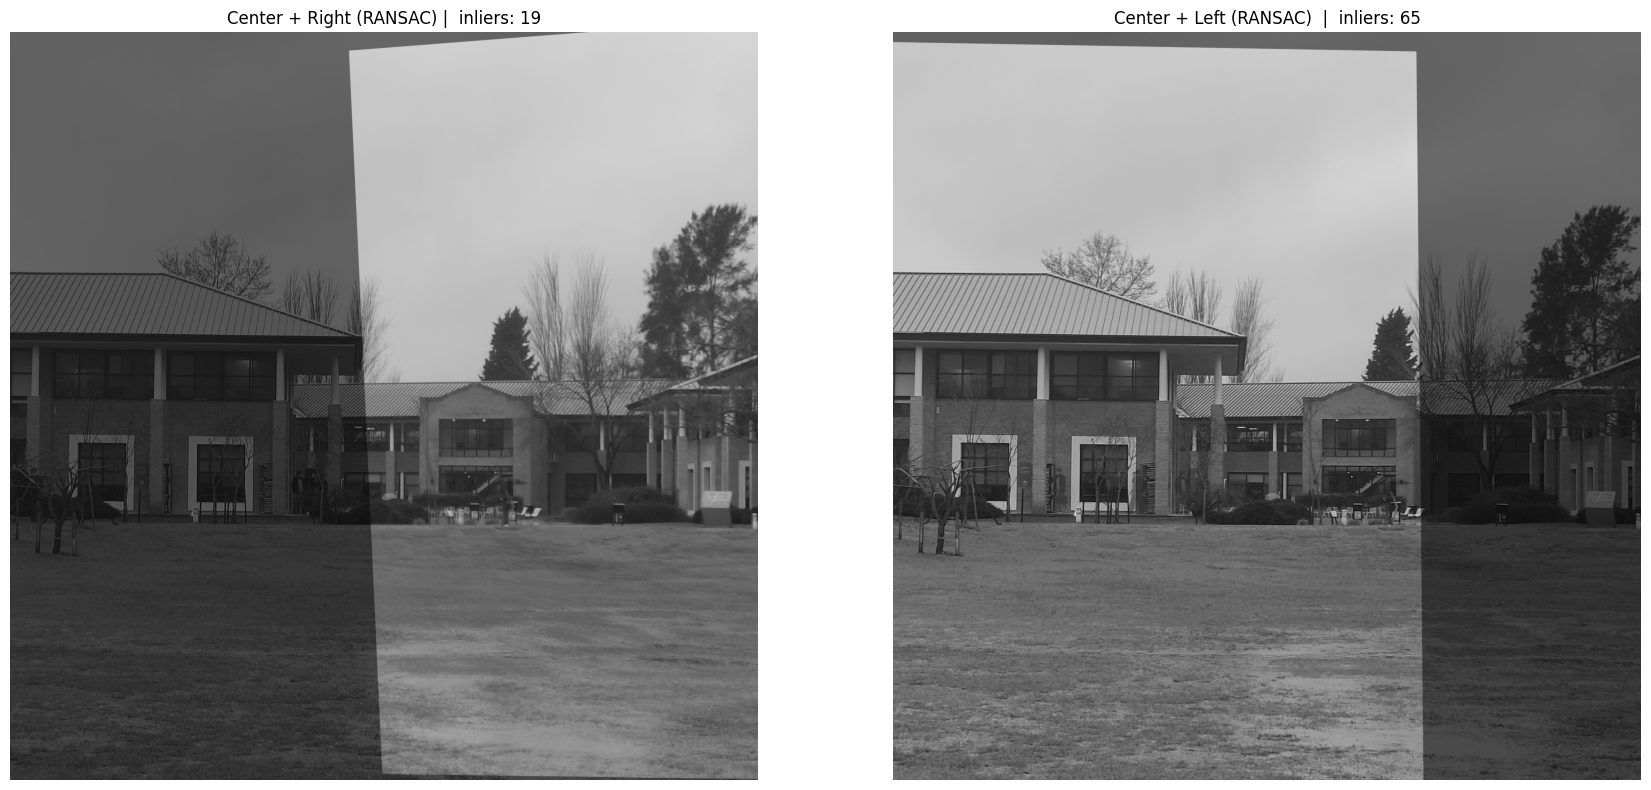

In [ ]:
# --- RANSAC LEFT ---
H_ransac_left, inliers_left = ransac_homography(
    ptsC_L, ptsL, thresh=5.0, max_iters=1000, confidence=0.99
)
print("Homografía con RANSAC H (center -> left):\n", H_ransac_left)

h, w = udesa_center.shape[:2]
img_left_warped_ransac = cv2.warpPerspective(
    udesa_left, np.linalg.inv(H_ransac_left), (w, h)
)
alpha = 0.5
overlay_left_ransac = cv2.addWeighted(
    cv2.cvtColor(udesa_center, cv2.COLOR_BGR2RGB), 1 - alpha,
    cv2.cvtColor(img_left_warped_ransac, cv2.COLOR_BGR2RGB), alpha, 0
)

# --- RANSAC RIGHT ---
H_ransac_right, inliers_right = ransac_homography(
    ptsC_R, ptsR, thresh=5.0, max_iters=1000, confidence=0.99
)
print("Homografía con RANSAC H (center -> right):\n", H_ransac_right)

img_right_warped_ransac = cv2.warpPerspective(
    udesa_right, np.linalg.inv(H_ransac_right), (w, h)
)
overlay_right_ransac = cv2.addWeighted(
    cv2.cvtColor(udesa_center, cv2.COLOR_BGR2RGB), 1 - alpha,
    cv2.cvtColor(img_right_warped_ransac, cv2.COLOR_BGR2RGB), alpha, 0
)

# --- UNA SOLA FIGURA, DOS SUBPLOTS ---
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

ax[1].imshow(overlay_left_ransac)
ax[1].set_title(f"Center + Left (RANSAC)  |  inliers: {len(inliers_left)}")
ax[1].axis("off")

ax[0].imshow(overlay_right_ransac)
ax[0].set_title(f"Center + Right (RANSAC) |  inliers: {len(inliers_right)}")
ax[0].axis("off")

plt.tight_layout()
plt.show()


#### Paso 6: Cálculo de tamaño óptimo para imagen final

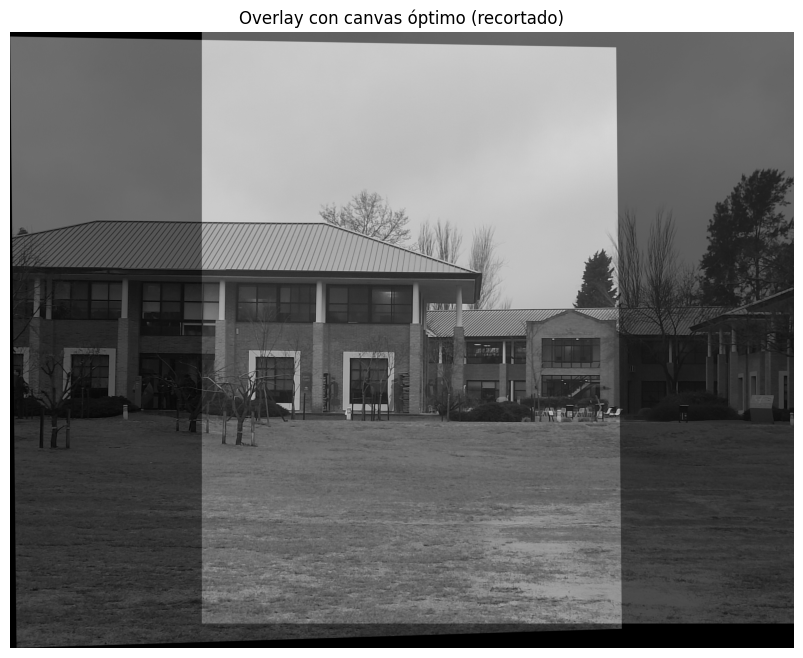

In [ ]:
# --- Recorte automático para obtener canvas óptimo ---
def warp_optimal(img_src, img_dst, H):
    """
    Aplica homografía H a img_src y devuelve la imagen warpeda sobre un canvas óptimo
    que incluye tanto la imagen destino como la fuente warpeda.
    """
    h_dst, w_dst = img_dst.shape[:2]
    h_src, w_src = img_src.shape[:2]

    # esquinas de la imagen fuente
    corners_src = np.array([
        [0, 0],
        [w_src, 0],
        [w_src, h_src],
        [0, h_src]
    ], dtype=np.float32)

    # transformar esquinas con H
    corners_src_h = np.hstack([corners_src, np.ones((4,1))])
    projected = (H @ corners_src_h.T).T
    projected /= projected[:, [2]]  # homogenizar
    projected = projected[:, :2]

    # esquinas de la imagen destino
    corners_dst = np.array([
        [0, 0],
        [w_dst, 0],
        [w_dst, h_dst],
        [0, h_dst]
    ], dtype=np.float32)

    # combinar esquinas
    all_corners = np.vstack([projected, corners_dst])

    # calcular bounding box
    x_min, y_min = np.floor(all_corners.min(axis=0)).astype(int)
    x_max, y_max = np.ceil(all_corners.max(axis=0)).astype(int)

    # traslación para evitar coordenadas negativas
    T = np.array([
        [1, 0, -x_min],
        [0, 1, -y_min],
        [0, 0, 1]
    ], dtype=np.float64)

    # nuevo tamaño de canvas
    new_w = x_max - x_min
    new_h = y_max - y_min

    # warpear imagen fuente al canvas
    warped_src = cv2.warpPerspective(img_src, T @ H, (new_w, new_h))

    # pegar imagen destino en el canvas
    warped_dst = np.zeros_like(warped_src)
    warped_dst[-y_min:h_dst - y_min, -x_min:w_dst - x_min] = img_dst

    return warped_src, warped_dst, (new_w, new_h)

# --- usar la función ---
warped_left, warped_center, (W, H) = warp_optimal(udesa_left, udesa_center, np.linalg.inv(H_ransac_left))

# overlay transparente
alpha = 0.5
overlay_optimal = cv2.addWeighted(cv2.cvtColor(warped_center, cv2.COLOR_BGR2RGB), 1-alpha,
                                  cv2.cvtColor(warped_left, cv2.COLOR_BGR2RGB), alpha, 0)

plt.figure(figsize=(12,8))
plt.imshow(overlay_optimal)
plt.title("Overlay con canvas óptimo (recortado)")
plt.axis("off")
plt.show()


#### Paso 7: Stitching and blending

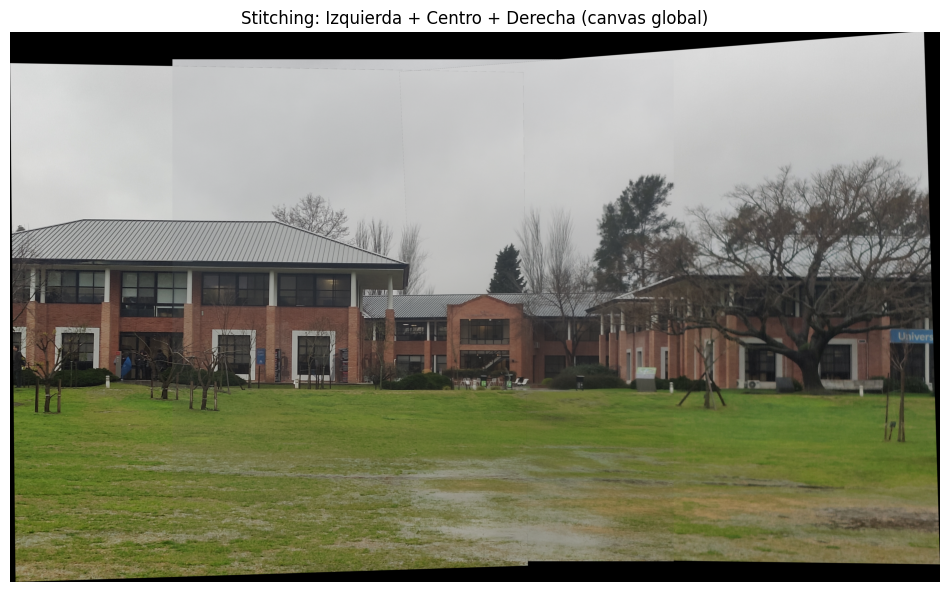

In [ ]:
# 1. Calculá las esquinas de las tres imágenes transformadas al sistema de la central
def get_corners(img, H):
    h, w = img.shape[:2]
    corners = np.array([[0,0],[w,0],[w,h],[0,h]], dtype=np.float32)
    corners_h = np.hstack([corners, np.ones((4,1))])
    projected = (H @ corners_h.T).T
    projected /= projected[:, [2]]
    return projected[:, :2]

corners_left = get_corners(udesa_left_original, np.linalg.inv(H_ransac_left))
corners_center = get_corners(udesa_center_original, np.eye(3))
corners_right = get_corners(udesa_right_original, np.linalg.inv(H_ransac_right))

all_corners = np.vstack([corners_left, corners_center, corners_right])
x_min, y_min = np.floor(all_corners.min(axis=0)).astype(int)
x_max, y_max = np.ceil(all_corners.max(axis=0)).astype(int)
new_w = x_max - x_min
new_h = y_max - y_min

# 2. Traslación para evitar negativos
T = np.array([
    [1, 0, -x_min],
    [0, 1, -y_min],
    [0, 0, 1]
], dtype=np.float64)

# 3. Warpear todas al mismo canvas
warped_left = cv2.warpPerspective(udesa_left_original, T @ np.linalg.inv(H_ransac_left), (new_w, new_h))
warped_center = cv2.warpPerspective(udesa_center_original, T, (new_w, new_h))
warped_right = cv2.warpPerspective(udesa_right_original, T @ np.linalg.inv(H_ransac_right), (new_w, new_h))

# 4. Blending
mask_left = (warped_left > 0).astype(np.float32)
mask_center = (warped_center > 0).astype(np.float32)
mask_right = (warped_right > 0).astype(np.float32)

blended = (warped_left * mask_left + warped_center * mask_center + warped_right * mask_right) / (mask_left + mask_center + mask_right + 1e-8)

plt.figure(figsize=(12,8))
plt.imshow(blended.astype(np.uint8))
plt.title("Stitching: Izquierda + Centro + Derecha (canvas global)")
plt.axis("off")
plt.show()